# Ансамбли решающих функций (классификаторов)

На сегодняшний день существуют два подхода:
    
* Баггинг (построение независимых классификаторов):
        - Bagging
        - Random Forests
        - ...
* Бустинг (новые классификаторы знают об ошибках других и учатся на их ошибках):
        - AdaBoost
        - Gradient Boosting
        - ...


Dataset: [armenian pubs](https://www.kaggle.com/erikhambardzumyan/pubs)

Подробнее о данных можно узнать в [первой работе](https://github.com/andrgolubev/python-sandbox/blob/master/data_analysis_1.ipynb)

## Плюсы и минусы ансамблей деревьев решений

** Плюсы **:

* Все достоинства деревьев решений сохраняются (кроме возможности интерпретации решающего правила - но остается возможность определения значимости признаков)
* Хорошее (часто рекордное) качество предсказания
* Random Forest (почти) не переобучается (GBT, AdaBoost - чуть похуже)

** Минусы **:

* GBT, AdaBoost - много параметров, которые надо подбирать
* Медленно обучаются (особенно GBT, который требует обычно много деревьев)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [18]:
import data_retrieve as dr
X, data = dr.parse_and_prepare("armenian_pubs.csv", sep=",", engine="python")
Y = None
Y_numeric = data['wts']
Y_mean = np.mean(Y_numeric)
Y = pd.Series(['C1' if val <= Y_mean else 'C2' for val in Y_numeric])
intY = pd.Series([0 if val is 'C1' else 1 for val in Y])
feature_names = X.columns

from sklearn.model_selection import train_test_split
# constant random_state to have repeatability
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=7)
N_train, _ = X_train.shape
N_test, _ = X_test.shape
intY = pd.Series([0 if val is 'C1' else 1 for val in Y_train])
intY_test = pd.Series([0 if val is 'C1' else 1 for val in Y_test])
print(N_train, N_test)

122 53


## Random Forest

Ансамбль параллельно обучаемых «независимых» деревьев решений.

Независимое построение определенного количества $M = {}$`n_estimators` (по умолчанию, 10) деревьев:

Генерация случайной bootstrap-подвыборки (по умолчанию, ее мощность равна $\sqrt{N}$) из обучающей выборки и построение дерева решений по данной подвыборке (в каждом
новом узле дерева переменная для разбиения выбирается не из всех признаков, а из
случайно выбранного их подмножества небольшой мощности).

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=700)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=700, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [20]:
err_train = np.mean(Y_train != rf_model.predict(X_train))
err_test = np.mean(Y_test != rf_model.predict(X_test))
print(err_train, err_test)

0.0 0.528301886792


## AdaBoost

Будем использовать веса $w_1,w_2, \dots ,w_N$.

На первой итерации $w_i = 1/N$ ($i = 1, 2, \dots ,N$) и алгоритм построения $f_1$ работает в
обычном режиме.
На $m$-й итерации увеличиваются веса тех прецедентов, на которых на $(m − 1)$-й
итерации была допущена ошибка, и уменьшаются веса тех прецедентов, которые на
предыдущей итерации были классифицированы правильно.

На $m$-й итерации ищем классификатор $f_m$, минимизирующий ошибку
$$
{\rm err}_m = \sum_{f_m(x^{(i)}) \ne y^{(i)}} w_i
$$


In [21]:
from sklearn.ensemble import AdaBoostClassifier
adab_model = AdaBoostClassifier(n_estimators=700)
adab_model.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=700, random_state=None)

In [22]:
err_train = np.mean(Y_train != adab_model.predict(X_train))
err_test = np.mean(Y_test != adab_model.predict(X_test))
print(err_train, err_test)

0.139344262295 0.509433962264


## Gradient Boosting

На каждой итерации строится новый классификатор, аппроксимирующий значение градиента функции потерь

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
gdb_model = GradientBoostingClassifier(n_estimators=700)
gdb_model.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=700, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [24]:
err_train = np.mean(Y_train != gdb_model.predict(X_train))
err_test = np.mean(Y_test != gdb_model.predict(X_test))
print(err_train, err_test)

0.0 0.547169811321


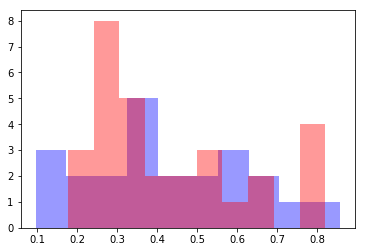

In [38]:
from ipywidgets import interact

defines = {
    'random_forest': {
        'ctor': RandomForestClassifier
    },
    'ada_boost': {
        'ctor': AdaBoostClassifier
    },
    'gradient_boosting': {
        'ctor': GradientBoostingClassifier
    }
}

names = X.columns
_, n_features = X.shape
def print_svc_data(model='random_forest', graph='hist', n_estimators=700):
    model_defines = defines[model]
    tree_model = model_defines['ctor'](n_estimators=n_estimators)
    tree_model.fit(X_train, Y_train)
    Y_train_predict = tree_model.predict(X_train)
    Y_test_predict = tree_model.predict(X_test)
    err_train = np.mean(Y_train != Y_train_predict)
    err_test = np.mean(Y_test != Y_test_predict)
    print(f"Errors: train - {err_train} | test - {err_test}")
    from sklearn.metrics import confusion_matrix
    cm_train = confusion_matrix(Y_train_predict, Y_train)
    print("Train data Confusion Matrix:\n", cm_train)
    cm_test = confusion_matrix(Y_test_predict, Y_test)
    print("Test data Confusion Matrix:\n", cm_test)
    
    tnr_tr = 1 - float(cm_train[1, 0])/(cm_train[0, 0] + cm_train[1, 0])
    tpr_tr = 1 - float(cm_train[0, 1])/(cm_train[0, 1] + cm_train[1, 1])
    print(f"Train data: Specificity={tnr_tr} | Sensitivity={tpr_tr}")
    tnr_tst = 1 - float(cm_test[1, 0])/(cm_test[0, 0] + cm_test[1, 0])
    tpr_tst = 1 - float(cm_test[0, 1])/(cm_test[0, 1] + cm_test[1, 1])
    print(f"Test data: Specificity={tnr_tst} | Sensitivity={tpr_tst}")
    probability = tree_model.predict_proba(X_test)[:, 1]
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(intY_test, probability)
    
    importances = tree_model.feature_importances_
    indices = np.argsort(importances)[:-11:-1]
    print("Feature ranking:")
    for f in range(10):
        print("%2d. feature '%5s' (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
    
    if graph is 'hist':
        plt.hist(probability[Y_test == 'C1'], color = 'b', alpha = 0.4, normed = False)
        plt.hist(probability[Y_test == 'C2'], color = 'r', alpha = 0.4, normed = False)
        pass
    else:
        from sklearn.metrics import roc_curve
        fpr, tpr, thresholds = roc_curve(intY_test, probability)
        plt.title('Receiver Operating Characteristic')
        plt.plot(np.concatenate(([0], fpr)), np.concatenate(([0], tpr)))
        #plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.axis([-0.05, 1.05, -0.05, 1.05])
        from sklearn.metrics import auc
        print("Area Under Curve: ", auc(fpr, tpr))
        pass
    pass

interact(print_svc_data, model=defines.keys(), graph=['hist', 'roc'], n_estimators=(1, 2500, 1))
pass